In [8]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import researchpy as rp


from sklearn.manifold import TSNE

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV,StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,auc,roc_curve,recall_score,precision_score,matthews_corrcoef
# from pandas_ml import ConfusionMatrix
import warnings
warnings.filterwarnings('ignore')
from imblearn.over_sampling import SMOTE,ADASYN
import imblearn.over_sampling as over
from IPython.display import display,clear_output,HTML

In [9]:
def RandomForest(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'RandomForest Classifier' + '\033[0m')
    rf=RandomForestClassifier(n_estimators=100,random_state=10)
    rf.fit(X_train,Y_train)
    return model_build(rf,X_train,Y_train,X_test,Y_test,True,feat)

def model_build(model,X_train,Y_train,X_test,Y_test,tree=False,feat=None):    
    y_pred_train=model.predict(X_train)
    acc_train=accuracy_score(Y_train,y_pred_train)
#     print("Accuracy of the model for training data is:",acc_train)
#     print("Confusion Matrix for training data is:")
#     cm_train=ConfusionMatrix(Y_train,y_pred_train)
#     display(cm_train)
#     y_pred_test=model.predict(X_test)
#     acc_test=accuracy_score(Y_test,y_pred_test)
#     print("Accuracy of the model for test data is:",acc_test)
#     print("Confusion Matrix for test data is:")
#     cm_test=ConfusionMatrix(Y_test,y_pred_test)
#     display(cm_test)
    
    print("Accuracy of the model for training data is:",accuracy_score(Y_train,model.predict(X_train)))
    print("Confusion Matrix for training data is:")
    y_pred_train=model.predict(X_train)
    display(pd.crosstab(Y_train,y_pred_train))
    y_pred_test=model.predict(X_test)
    acc_test=accuracy_score(Y_test,y_pred_test)
    print("Accuracy of the model for test data is:",acc_test)
    print("Confusion Matrix for test data is:")
    display(pd.crosstab(Y_test,y_pred_test))
    
    fpr, tpr, threshold = roc_curve(Y_test, y_pred_test)
    roc_auc =auc(fpr, tpr)
    mcc=matthews_corrcoef(Y_test,y_pred_test)
    precision=precision_score(Y_test,y_pred_test)
    recall=recall_score(Y_test,y_pred_test)
#     if tree==True:
#         feat_impt_plot(model.feature_importances_,feat)
#         return model,cm_train,cm_test,acc_train,acc_test,roc_auc,model.feature_importances_,mcc,precision,recall
    return model,acc_train,acc_test,roc_auc,mcc,precision,recall

### Function to plot Feature Importance
def feat_impt_plot(feat_impt,y_labels,width_s=1000,height_s=1000):
    
    m=pd.DataFrame(y_labels,feat_impt).reset_index()
    m.columns=['Feature_Importance','Features']
    m.sort_values(by='Feature_Importance',inplace=True,ascending=False)
    m['Features']=m['Features'].str.replace("dom_function_","")
    m['Features']=m['Features'].str.replace("js_function_","")
    m['Features']=m['Features'].apply(lambda x: str(x).lstrip('.'))
    m['Features']=m['Features'].str.replace("(","")
    
    data = [go.Bar(x=m.Feature_Importance.values,y=m.Features.values,text=np.round(m.Feature_Importance,4),
            textposition = 'outside',
            marker=dict(
                color='rgb(158,202,225)',
                line=dict(
                    color='rgb(8,48,107)',
                    width=1.5),
            ),
            opacity=0.6,
            orientation='h'
        )]
    layout = go.Layout(autosize=False,
    width=width_s,
    height=height_s,
    xaxis=dict(title='Feature Importances',
        tickfont=dict(
            size=12,
            color='black'
        )),
    yaxis=dict(automargin=True))
    fig = go.Figure(data=data, layout=layout)
    iplot(fig)

In [10]:
df_train=pd.read_csv('../../Data/Training_Data/df_training.csv',index_col='domain')

# df_mal=pd.read_csv('../Data/Malicious_domains.csv')
# # mal_domains=df_mal.queried_domain.values.tolist()

df_test=pd.read_csv('../../Data/Test_Data/df_fin.csv',index_col='domain')
# df_test.reset_index(inplace=True)
# # df_test['Target']=df_test['domain'].apply(lambda x: 1 if x in mal_domains else 0)
# # df_test.set_index(['domain'],inplace=True)

In [11]:
df=pd.concat([df_test,df_train],axis=0,sort=False)
df=df.sample(frac=1,random_state=10)

#### Training - 20% of Combined Dataset1 and Dataset2 used. 

In [12]:
columns=df.columns.tolist()
train=df.iloc[:int(df.shape[0]*0.2),:]
train_X=train.iloc[:,train.columns!='Target'].values
train_Y=train.Target.values

scaler=StandardScaler()
scaled_X_train=scaler.fit_transform(train_X)

test=df.iloc[int(df.shape[0]*0.2):,:]
test_X=test.iloc[:,test.columns!='Target'].values
test_Y=test.Target.values
scaled_X_test=scaler.transform(test_X)
columns.remove('Target')

model,acc_train,acc_test,roc_auc,mcc,prec,rec=RandomForest(scaled_X_train,train_Y,scaled_X_test,test_Y,columns)
print("MCC:",mcc)
print("AUC:",roc_auc)
print("Precision:",prec)
print("Recall:",rec)

RandomForest Classifier
Accuracy of the model for training data is: 0.9978318384911792
Confusion Matrix for training data is:


col_0,0,1
row_0,,
0,174079,17
1,378,7708


Accuracy of the model for test data is: 0.9574205022154951
Confusion Matrix for test data is:


col_0,0,1
row_0,,
0,695131,1000
1,30029,2571


MCC: 0.22921519106712007
AUC: 0.5387142597217418
Precision: 0.7199663959675161
Recall: 0.07886503067484663


#### Training - 30% of Combined Dataset1 and Dataset2 used.

In [13]:
columns=df.columns.tolist()
train=df.iloc[:int(df.shape[0]*0.3),:]
train_X=train.iloc[:,train.columns!='Target'].values
train_Y=train.Target.values

scaler=StandardScaler()
scaled_X_train=scaler.fit_transform(train_X)

test=df.iloc[int(df.shape[0]*0.3):,:]
test_X=test.iloc[:,test.columns!='Target'].values
test_Y=test.Target.values
scaled_X_test=scaler.transform(test_X)
columns.remove('Target')
model,acc_train,acc_test,roc_auc,mcc,prec,rec=RandomForest(scaled_X_train,train_Y,scaled_X_test,test_Y,columns)
print("MCC:",mcc)
print("AUC:",roc_auc)
print("Precision:",prec)
print("Recall:",rec)

RandomForest Classifier
Accuracy of the model for training data is: 0.9973725907791842
Confusion Matrix for training data is:


col_0,0,1
row_0,,
0,261087,28
1,690,11468


Accuracy of the model for test data is: 0.9576281287246722
Confusion Matrix for test data is:


col_0,0,1
row_0,,
0,608292,820
1,26198,2330


MCC: 0.2368553009182871
AUC: 0.5401639613293385
Precision: 0.7396825396825397
Recall: 0.08167414469994391


#### Training - 40% of Combined Dataset1 and Dataset2 used.

In [15]:
columns=df.columns.tolist()
train=df.iloc[:int(df.shape[0]*0.4),:]
train_X=train.iloc[:,train.columns!='Target'].values
train_Y=train.Target.values

scaler=StandardScaler()
scaled_X_train=scaler.fit_transform(train_X)

test=df.iloc[int(df.shape[0]*0.4):,:]
test_X=test.iloc[:,test.columns!='Target'].values
test_Y=test.Target.values
scaled_X_test=scaler.transform(test_X)
columns.remove('Target')
model,acc_train,acc_test,roc_auc,mcc,prec,rec=RandomForest(scaled_X_train,train_Y,scaled_X_test,test_Y,columns)
print("MCC:",mcc)
print("AUC:",roc_auc)
print("Precision:",prec)
print("Recall:",rec)

RandomForest Classifier
Accuracy of the model for training data is: 0.9972390322890509
Confusion Matrix for training data is:


col_0,0,1
row_0,,
0,348116,28
1,978,15243


Accuracy of the model for test data is: 0.9576853268148452
Confusion Matrix for test data is:


col_0,0,1
row_0,,
0,521372,711
1,22416,2049


MCC: 0.24035319144087666
AUC: 0.5411952233885896
Precision: 0.7423913043478261
Recall: 0.08375229920294298


#### Training - 50% of Combined Dataset1 and Dataset2 used.

In [16]:
columns=df.columns.tolist()
train=df.iloc[:int(df.shape[0]*0.5),:]
train_X=train.iloc[:,train.columns!='Target'].values
train_Y=train.Target.values

scaler=StandardScaler()
scaled_X_train=scaler.fit_transform(train_X)

test=df.iloc[int(df.shape[0]*0.5):,:]
test_X=test.iloc[:,test.columns!='Target'].values
test_Y=test.Target.values
scaled_X_test=scaler.transform(test_X)
columns.remove('Target')
model,acc_train,acc_test,roc_auc,mcc,prec,rec=RandomForest(scaled_X_train,train_Y,scaled_X_test,test_Y,columns)
print("MCC:",mcc)
print("AUC:",roc_auc)
print("Precision:",prec)
print("Recall:",rec)

RandomForest Classifier
Accuracy of the model for training data is: 0.9970447200168622
Confusion Matrix for training data is:


col_0,0,1
row_0,,
0,435006,39
1,1307,19104


Accuracy of the model for test data is: 0.958059707063455
Confusion Matrix for test data is:


col_0,0,1
row_0,,
0,434573,609
1,18493,1782


MCC: 0.2468435012997302
AUC: 0.5432460387436806
Precision: 0.7452948557089084
Recall: 0.08789149198520345


#### Training - 60% of Combined Dataset1 and Dataset2 used.

In [17]:
columns=df.columns.tolist()
train=df.iloc[:int(df.shape[0]*0.6),:]
train_X=train.iloc[:,train.columns!='Target'].values
train_Y=train.Target.values

scaler=StandardScaler()
scaled_X_train=scaler.fit_transform(train_X)

test=df.iloc[int(df.shape[0]*0.6):,:]
test_X=test.iloc[:,test.columns!='Target'].values
test_Y=test.Target.values
scaled_X_test=scaler.transform(test_X)
columns.remove('Target')
model,acc_train,acc_test,roc_auc,mcc,prec,rec=RandomForest(scaled_X_train,train_Y,scaled_X_test,test_Y,columns)
print("MCC:",mcc)
print("AUC:",roc_auc)
print("Precision:",prec)
print("Recall:",rec)

RandomForest Classifier
Accuracy of the model for training data is: 0.9969279860652424
Confusion Matrix for training data is:


col_0,0,1
row_0,,
0,521892,63
1,1616,22976


Accuracy of the model for test data is: 0.9583385936119176
Confusion Matrix for test data is:


col_0,0,1
row_0,,
0,347761,511
1,14669,1425


MCC: 0.24610495870087556
AUC: 0.5435375349563014
Precision: 0.7360537190082644
Recall: 0.0885423139058034


#### Training - 70% of Combined Dataset1 and Dataset2 used.

In [18]:
columns=df.columns.tolist()
train=df.iloc[:int(df.shape[0]*0.7),:]
train_X=train.iloc[:,train.columns!='Target'].values
train_Y=train.Target.values

scaler=StandardScaler()
scaled_X_train=scaler.fit_transform(train_X)

test=df.iloc[int(df.shape[0]*0.7):,:]
test_X=test.iloc[:,test.columns!='Target'].values
test_Y=test.Target.values
scaled_X_test=scaler.transform(test_X)
columns.remove('Target')
model,acc_train,acc_test,roc_auc,mcc,prec,rec=RandomForest(scaled_X_train,train_Y,scaled_X_test,test_Y,columns)
print("MCC:",mcc)
print("AUC:",roc_auc)
print("Precision:",prec)
print("Recall:",rec)

RandomForest Classifier
Accuracy of the model for training data is: 0.9968273584269469
Confusion Matrix for training data is:


col_0,0,1
row_0,,
0,608950,90
1,1933,26666


Accuracy of the model for test data is: 0.9583055834071298
Confusion Matrix for test data is:


col_0,0,1
row_0,,
0,260793,394
1,11000,1087


MCC: 0.24762974138349353
AUC: 0.5442114167196328
Precision: 0.7339635381498987
Recall: 0.08993133118226193


### OverSampling

#### Training - 30% of Combined Dataset1 and Dataset2 used.
#### Oversampling ratio 1:1. Technique - SMOTE

In [19]:
columns=df.columns.tolist()
train=df.iloc[:int(df.shape[0]*0.3),:]
train_X=train.iloc[:,train.columns!='Target'].values
train_Y=train.Target.values

scaler=StandardScaler()
scaled_X_train=scaler.fit_transform(train_X)

test=df.iloc[int(df.shape[0]*0.3):,:]
test_X=test.iloc[:,test.columns!='Target'].values
test_Y=test.Target.values
scaled_X_test=scaler.transform(test_X)
columns.remove('Target')

In [28]:
train.Target.value_counts()

sm = SMOTE(random_state=12, ratio ={1 : 261115} )
X_train, Y_train = sm.fit_sample(scaled_X_train,train_Y)

model,acc_train,acc_test,roc_auc,mcc,prec,rec=RandomForest(X_train,Y_train,scaled_X_test,test_Y,columns)
print("MCC:",mcc)
print("AUC:",roc_auc)
print("Precision:",prec)
print("Recall:",rec)

RandomForest Classifier
Accuracy of the model for training data is: 0.9974053577925435
Confusion Matrix for training data is:


col_0,0,1
row_0,,
0,260531,584
1,771,260344


Accuracy of the model for test data is: 0.9547879681324886
Confusion Matrix for test data is:


col_0,0,1
row_0,,
0,606170,2942
1,25887,2641


MCC: 0.194714507591419
AUC: 0.5438728665401694
Precision: 0.47304316675622426
Recall: 0.09257571508693213


#### Training - 30% of Combined Dataset1 and Dataset2 used.
#### Oversampling ratio 1:1. Technique - ADASYN

### Note - I noticed a mistake in the execution of the below results. Please ignore it.

In [30]:
sm = ADASYN(random_state=12, ratio = {1:261115},n_neighbors=10,n_jobs=-1)
X_train, Y_train = sm.fit_sample(scaled_X_train,train_Y)

model,acc_train,acc_test,roc_auc,mcc,prec,rec=RandomForest(X_train,Y_train,scaled_X_test,test_Y,columns)
print("MCC:",mcc)
print("AUC:",roc_auc)
print("Precision:",prec)
print("Recall:",rec)

RandomForest Classifier
Accuracy of the model for training data is: 0.9978290210493065
Confusion Matrix for training data is:


col_0,0,1
row_0,,
0,260911,204
1,930,260300


Accuracy of the model for test data is: 0.9556317044100119
Confusion Matrix for test data is:


col_0,0,1
row_0,,
0,606839,2273
1,26018,2510


MCC: 0.2018653847467512
AUC: 0.5421260367242994
Precision: 0.5247752456617186
Recall: 0.08798373527762199


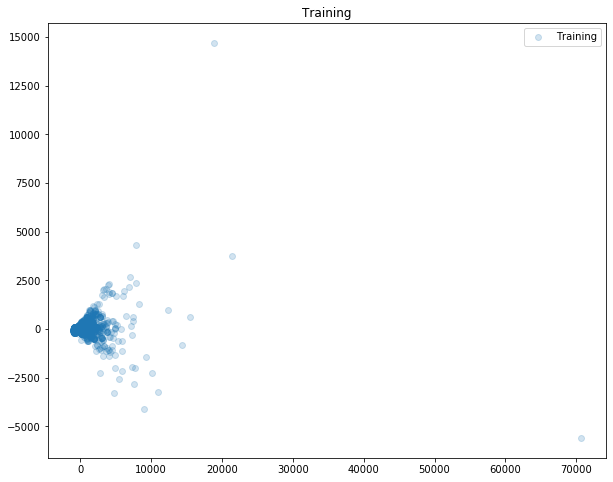

In [58]:
data=df.iloc[:,df.columns!='Target'].sample(n=5000,random_state=0)
tsne = TSNE(n_components=2, init='pca')
X = tsne.fit_transform(data)
_, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.scatter(X[:, 0], X[:, 1], label='Training', alpha=0.2)
ax.set_title('Training')
ax.legend()
plt.axis('tight')
plt.show()  

In [76]:
data=df.iloc[:,df.columns!='Target'].sample(n=40000,random_state=0)
target=df.iloc[:,df.columns=='Target'].sample(n=40000,random_state=0)
tsne = TSNE(n_components=2, init='pca')
X = tsne.fit_transform(data)

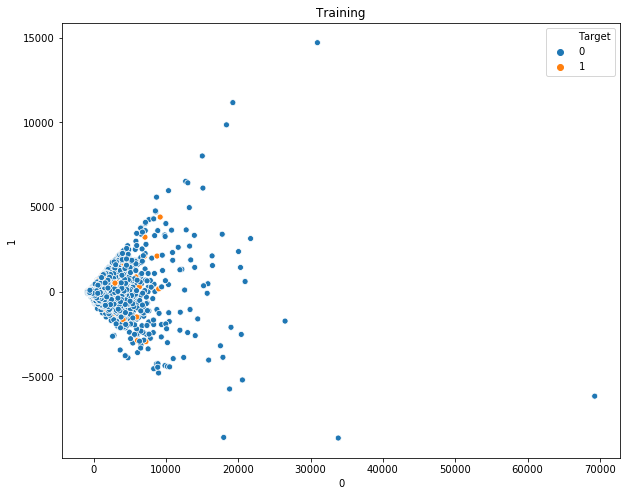

In [77]:
tsne_df=pd.concat([pd.DataFrame(X),target.reset_index(drop=True)],axis=1)
_, ax = plt.subplots(1, 1, figsize=(10, 8))
ax=sns.scatterplot(tsne_df[0],tsne_df[1],hue='Target',data=tsne_df)
ax.set_title('Training')
ax.legend()
plt.axis('tight')
plt.show()  

In [31]:
### Original Creator : Darshan Bhansali
### HTML code to hide the input cells 
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To toggle code, click <a href="javascript:code_toggle()">here</a>.''')